In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt # data visualization
import seaborn as sns # datta visualization
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, Normalizer
from collections import Counter
from catboost import CatBoostClassifier

R_STATE = 42

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/machine-failure-predictions/machine failure.csv
/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv


In [28]:
sample = pd.read_csv("/kaggle/input/playground-series-s3e17/sample_submission.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e17/test.csv")
train = pd.read_csv("/kaggle/input/playground-series-s3e17/train.csv")
real = pd.read_csv("/kaggle/input/machine-failure-predictions/machine failure.csv")

In [29]:
def rename_columns(df) -> pd.DataFrame:
    df.columns = (col_name.replace(" ","_").lower() for col_name in df.columns)
    
def standardize_features(train_data: pd.DataFrame,test_data: pd.DataFrame, feature_names: list):
    """Standardizes numerical features and returns the scaler and standardized train and test dataframes"""
    scaler = StandardScaler()
    df_copy , test_df = train_data.copy(), test_data.copy()
    df_copy[feature_names] = scaler.fit_transform(df_copy[feature_names])
    test_df[feature_names] = scaler.transform(test_df[feature_names])
    
    return scaler, df_copy, test_df


def submission_csv(trained_model, test_data, filename, neural= False):
    preds = [val[0] for val in trained_model.predict(test_data)] if neural else trained_model.predict_proba(test_data)[:, 1] 
    df_ = pd.DataFrame(zip(range(136429, 227383 ), preds), columns= ["id", "Machine Failure"])
    df_.to_csv(f"{filename}.csv", index=False)

In [30]:
rename_columns(real)
rename_columns(test)
rename_columns(train)
real

,udi,product_id,type,air_temperature_[k],process_temperature_[k],rotational_speed_[rpm],torque_[nm],tool_wear_[min],machine_failure,twf,hdf,pwf,osf,rnf
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [31]:
real.machine_failure.value_counts(), real.machine_failure.value_counts(normalize=True)

(0    9661
 1     339
 Name: machine_failure, dtype: int64,
 0    0.9661
 1    0.0339
 Name: machine_failure, dtype: float64)

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       136429 non-null  int64  
 1   product_id               136429 non-null  object 
 2   type                     136429 non-null  object 
 3   air_temperature_[k]      136429 non-null  float64
 4   process_temperature_[k]  136429 non-null  float64
 5   rotational_speed_[rpm]   136429 non-null  int64  
 6   torque_[nm]              136429 non-null  float64
 7   tool_wear_[min]          136429 non-null  int64  
 8   machine_failure          136429 non-null  int64  
 9   twf                      136429 non-null  int64  
 10  hdf                      136429 non-null  int64  
 11  pwf                      136429 non-null  int64  
 12  osf                      136429 non-null  int64  
 13  rnf                      136429 non-null  int64  
dtypes: f

In [33]:
train.machine_failure.value_counts(), train.machine_failure.value_counts(normalize=True)

(0    134281
 1      2148
 Name: machine_failure, dtype: int64,
 0    0.984256
 1    0.015744
 Name: machine_failure, dtype: float64)

In [34]:
sum(train.duplicated())

0

In [35]:
train

,id,product_id,type,air_temperature_[k],process_temperature_[k],rotational_speed_[rpm],torque_[nm],tool_wear_[min],machine_failure,twf,hdf,pwf,osf,rnf
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136424,136424,M22284,M,300.1,311.4,1530,37.5,210,0,0,0,0,0,0
136425,136425,H38017,H,297.5,308.5,1447,49.1,2,0,0,0,0,0,0
136426,136426,L54690,L,300.5,311.8,1524,38.5,214,0,0,0,0,0,0
136427,136427,L53876,L,301.7,310.9,1447,46.3,42,0,0,0,0,0,0


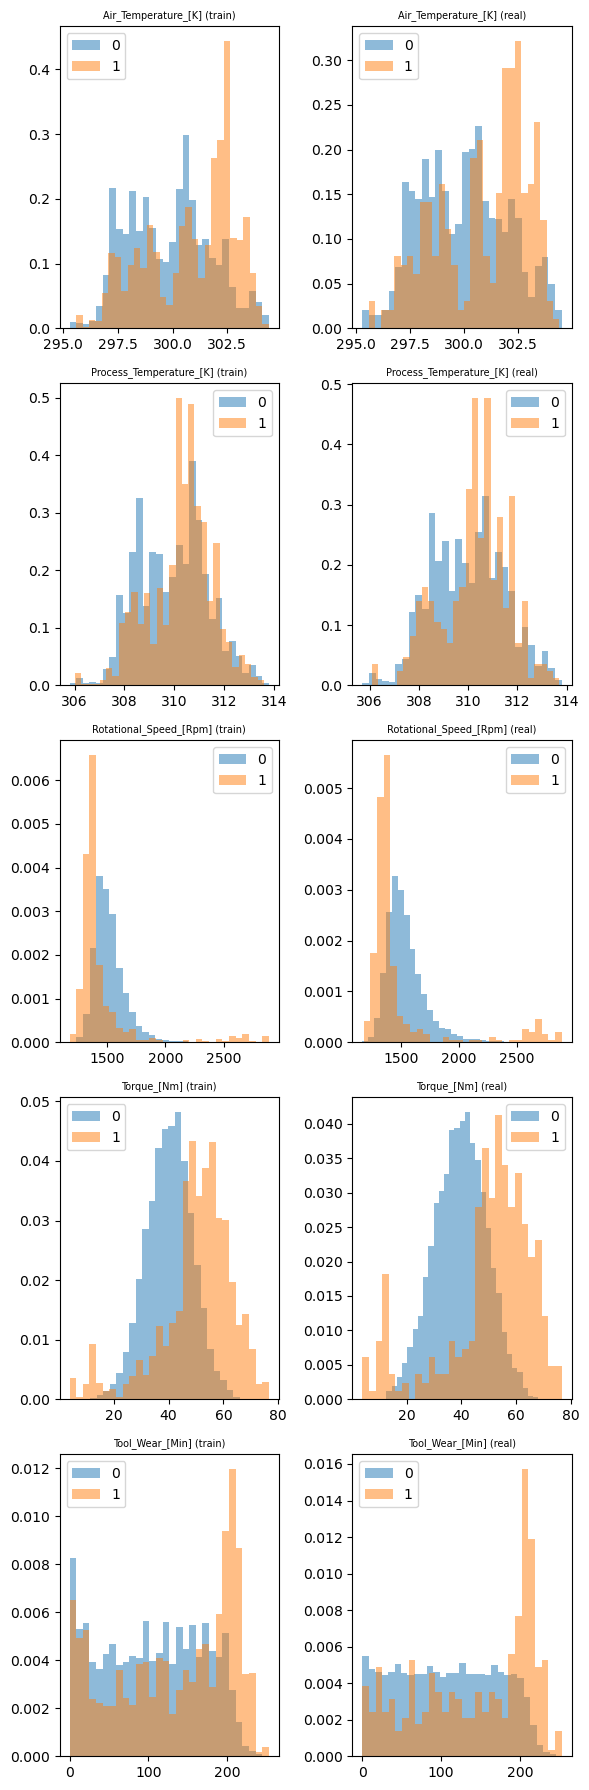

In [36]:
num_features = ["air_temperature_[k]","process_temperature_[k]", "rotational_speed_[rpm]","torque_[nm]", "tool_wear_[min]"]
target = "machine_failure"
fig, axs = plt.subplots(len(num_features), 2, figsize=(6, 18))
df_list = [train, real]

for i, df in enumerate(df_list):
    for j, ft in enumerate(num_features):
        data1 = df[df[target] == 0][ft]
        data2 = df[df[target] == 1][ft]
        ax1 = axs[j, i]
        ax1.hist(data1, bins=30, alpha=0.5, label='0', density=True)
        ax1.hist(data2, bins=30, alpha=0.5, label='1', density=True)
        ax1.set_title(
            f"{ft.title()} ({['train', 'real'][i]})", size=7)
        ax1.legend()
        

plt.tight_layout()
plt.show()

## Frequency encoding high cardinality feature product id

In [37]:
product_freq = train['product_id'].value_counts(normalize=True).reset_index()
product_freq.columns = ['product_id', 'frequency']
product_freq.frequency = product_freq.frequency.apply(lambda x : x * 100)
product_freq_dict = product_freq.set_index('product_id')['frequency'].to_dict()

def preprocess(df):
    #dropping columns
    cols_to_drop = ["rnf", "id"]
    df.drop(cols_to_drop, axis=1, inplace=True)
    #freq encoding
    df.product_id = df.product_id.apply(lambda x: product_freq_dict.get(x, -1))
    #encoding type feature
    return pd.get_dummies(df)
    


In [38]:
train = preprocess(train)
test = preprocess(test)


# Using SMOTE to balance the smaller class

In [39]:
sm = SMOTE(random_state=R_STATE)
X_res, y_res = sm.fit_resample(train.drop("machine_failure", axis=1), train.machine_failure)

In [40]:
sum(y_res) / X_res.shape[0]

0.5

## Standardization

In [41]:
_, X_std , test_std = standardize_features(X_res, test, num_features)
X_std

,product_id,air_temperature_[k],process_temperature_[k],rotational_speed_[rpm],torque_[nm],tool_wear_[min],twf,hdf,pwf,osf,type_H,type_L,type_M
0,0.018325,0.119592,-0.415099,0.491063,-0.768263,0.311448,0,0,0,0,0,1,0
1,0.014660,1.187058,1.590927,1.222133,-1.362852,1.167288,0,0,0,0,0,0,1
2,0.024188,-0.574260,-1.297750,1.428447,-1.583699,-1.328912,0,0,0,0,0,1,0
3,0.021256,0.333085,0.628035,0.168137,-0.071744,1.124496,0,0,0,0,0,1,0
4,0.005864,-1.268113,-0.896545,0.692892,-0.827722,-1.200536,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
268557,0.025010,-0.837361,-1.051779,-0.074058,-0.464222,-1.642720,0,0,0,0,0,1,0
268558,0.013298,-1.355942,-1.569706,-0.715426,1.523727,0.610992,0,0,0,0,0,1,0
268559,0.012209,1.076649,0.154847,-0.625724,0.351257,0.610992,0,1,0,0,0,0,0
268560,0.040634,1.809496,2.078026,-0.589844,0.027912,1.110232,0,0,0,0,0,0,0


In [42]:
VALIDATION_SIZE = 21000

# standardized
x_train_full_std, x_test_std, y_train_full_std, y_test_std =  train_test_split(X_std, y_res, test_size=0.1)                  
x_valid_std, x_train_std =  x_train_full_std[:VALIDATION_SIZE], x_train_full_std[VALIDATION_SIZE:]
y_valid_std, y_train_std =  y_train_full_std[:VALIDATION_SIZE], y_train_full_std[VALIDATION_SIZE:]

# regular
x_train_full, x_test, y_train_full, y_test =  train_test_split(X_res, y_res, test_size=0.1)                  
x_valid, x_train =  x_train_full[:VALIDATION_SIZE], x_train_full[VALIDATION_SIZE:]
y_valid, y_train =  y_train_full[:VALIDATION_SIZE], y_train_full[VALIDATION_SIZE:]



In [43]:
rf = RandomForestClassifier(n_estimators = 250, random_state= R_STATE)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
accuracy_score(y_test, rf_pred)

0.9900956919983617

In [44]:
logreg = LogisticRegression(random_state=R_STATE,C= 0.4,max_iter=1000)
logreg.fit(x_train_std, y_train_std)
lr_pred = logreg.predict(x_test_std)
accuracy_score(y_test_std, lr_pred)

0.8831589529731542

In [45]:
indexes = range(136429, 227383 )
#submission_csv(rf,test, "rf" )

In [46]:
from tensorflow import keras
from tensorflow.keras import layers

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, 
                                                  restore_best_weights=True, 
                                                  monitor="val_loss",
                                                  mode="min")


# Define the Keras model
neural = keras.Sequential()
neural.add(layers.Dense(64, input_dim=x_train_std.shape[1], activation='relu'))
neural.add(layers.Dropout(0.2))
neural.add(layers.Dense(32, activation='relu'))
neural.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
neural.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

optimizer = keras.optimizers.Nadam(learning_rate=0.005)

epochs = 10
# Train the model
history = neural.fit(x_train_std, y_train_std, validation_data=(x_valid_std, y_valid_std), epochs=epochs, callbacks=[early_stopping_cb])

Epoch 1/10
6898/6898 [==============================] - 15s 2ms/step - loss: 0.2363 - accuracy: 0.9053 - val_loss: 0.2157 - val_accuracy: 0.9131
Epoch 2/10
6898/6898 [==============================] - 14s 2ms/step - loss: 0.2145 - accuracy: 0.9134 - val_loss: 0.2111 - val_accuracy: 0.9130
Epoch 3/10
6898/6898 [==============================] - 14s 2ms/step - loss: 0.2080 - accuracy: 0.9151 - val_loss: 0.2043 - val_accuracy: 0.9158
Epoch 4/10
6898/6898 [==============================] - 13s 2ms/step - loss: 0.2033 - accuracy: 0.9169 - val_loss: 0.2010 - val_accuracy: 0.9167
Epoch 5/10
6898/6898 [==============================] - 14s 2ms/step - loss: 0.1997 - accuracy: 0.9186 - val_loss: 0.1967 - val_accuracy: 0.9187
Epoch 6/10
6898/6898 [==============================] - 13s 2ms/step - loss: 0.1979 - accuracy: 0.9200 - val_loss: 0.1949 - val_accuracy: 0.9203
Epoch 7/10
6898/6898 [==============================] - 13s 2ms/step - loss: 0.1962 - accuracy: 0.9200 - val_loss: 0.1941 - val_ac

In [47]:
nn_pred = [round(val[0]) for val in neural.predict(x_test_std)]
accuracy_score(y_test_std, nn_pred)
#submission_csv(neural, test_std, "NN", True)

840/840 [==============================] - 1s 1ms/step


0.9265368432810813

In [48]:
xgb_classifier = XGBClassifier(
    n_estimators= 200,
    objective='binary:logistic',
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.01,  # L1 regularization parameter
)

#xgb_classifier.fit(x_train_std, y_train_std)
#xgb_pred = xgb_classifier.predict(x_test_std)



In [53]:
cat = CatBoostClassifier(verbose=False)
cat.fit(x_train,y_train)
cat_pred = cat.predict(x_test)
accuracy_score(y_test, cat_pred)


0.9969840265107793

In [ ]:
submission_csv(cat, test, "catboost default")